#### This script is based on poster_plots_1.ipynb from cluster_8b.

In [1]:
# ------------------------------------------------------------------------------
# analysis.py
# Author: Dr. Timo Hofsähs
#
# Description: 
# This Python script is part of the code accompanying the scientific publication:
# The Virtual Brain links transcranial magnetic stimulation evoked potentials and 
# neurotransmitter changes in major depressive disorder
# Dr. Timo Hofsähs, Marius Pille, Dr. Jil Meier, Prof. Petra Ritter
# (in prep)
# 
# This code is used to analyze the results generated with 'simulation.py'. 
# It reads data and results, performs the statistical analysis and plots the results.
#
# Copyright (c) 2024 Dr. Timo Hofsähs. All rights reserved.
#
# License: This code is licensed under the Creative Commons Attribution 4.0 International 
# License (CC-BY 4.0), which allows for redistribution, adaptation, and use in source 
# and binary forms, with or without modification, provided proper credit is given to 
# the original authors. You can view the full terms of this license at:
# https://creativecommons.org/licenses/by/4.0/
# ------------------------------------------------------------------------------

In [2]:
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import multiprocessing as mp
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import seaborn as sns
import zipfile

from functions import gmfa, gmfa_timepoint
# from functools import partial
from matplotlib.font_manager import FontProperties
# from multiprocessing.pool import ThreadPool as Pool
from scipy import stats
# from scipy.stats import mannwhitneyu
# from scipy.stats import shapiro

In [3]:
# DEFINE VARIABLES
dir_exp = f"./analysis/"
if not os.path.exists(dir_exp):
    os.makedirs(dir_exp)

subs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
subs_bids = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
runs = np.arange(0,100)
n_epochs = 150
sim_duration = 1400
dtx = 0.25
ts = np.arange(0, sim_duration / dtx)

file_sc_weights = './data/Schaefer2018_200Parcels_7Networks_count.csv'
file_sc_distances = './data/Schaefer2018_200Parcels_7Networks_distance.csv'
file_empirical_timeseries = './data/TEPs.mat'
file_leadfield_matrix = './data/leadfield'
file_stimulus = './data/stimulus_weights.npy'

sc_weights_original = pd.read_csv(file_sc_weights, header=None, sep=' ').values
sc_weights_norm = np.log1p(sc_weights_original)/np.linalg.norm(np.log1p(sc_weights_original))
sc_distances = pd.read_csv(file_sc_distances, header=None, sep=' ').values
empirical_timeseries = scipy.io.loadmat(file_empirical_timeseries)['meanTrials'][0][2][0]
leadfield_matrix = np.load(file_leadfield_matrix, allow_pickle=True)
stimulus_spatial = np.load(file_stimulus)

factors_explore = ['jr_b', 'jr_c4']
range_low = 0.5
range_high = 1.501
range_step_size = 0.02
factors_values = np.round(np.arange(range_low, range_high, range_step_size),5)
parameter_description = ['b (1/s)', 'C4']
factors_values_b_c4 = np.vstack((factors_values * 50, factors_values * 33.75))

In [4]:
# SETTINGS PLOTTING
resolution=500
fig_width=15

# font
fontsize_title = 28
fontsize_title_axes = 25
fontsize_axes = 20
fontsize_label = 17
fontsize_legend = 15
font_style = 'Helvetica'
plt.rcParams["font.family"] = font_style
plt.rcParams['font.size'] = fontsize_label
plt.rcParams['figure.titlesize'] = fontsize_title
plt.rcParams['axes.titlesize'] = fontsize_title_axes
plt.rcParams['axes.labelsize'] = fontsize_axes
plt.rcParams['xtick.labelsize'] = fontsize_label
plt.rcParams['ytick.labelsize'] = fontsize_label
plt.rcParams['legend.fontsize'] = fontsize_legend

# color
cmap_custom_mult_colors = [(0, "black"),(0.1, (0.0, 0.325, 0.51)),(0.25, (0.0, 0.718, 1.0)),(0.5, (0.824, 0.0, 0.467)),(0.7, (0.969, 0.38, 0.69)),(0.9, (0.994, 0.852, 0.991)),(1, "white")]
cmap_custom_mult = mcolors.LinearSegmentedColormap.from_list('cmap_custom_mult', cmap_custom_mult_colors)
cmap_custom_mult.set_bad(color='black')
cmap_custom_binary_colors = [(0, (0.0, 0.313, 0.573)),(0.5, "white"),(1, (0.616, 0.0, 0.345))]
cmap_custom_binary = mcolors.LinearSegmentedColormap.from_list('cmap_custom_binary', cmap_custom_binary_colors)
cmap_custom_binary.set_bad(color='black')
cmap_custom_stim_colors = [(0, (0.0, 0.325, 0.51)),(0.01, (0.0, 0.718, 1.0)),(0.3, (0.994, 0.852, 0.991)),(0.6, (0.969, 0.38, 0.69)),(1.0, (0.824, 0.0, 0.467)),]
cmap_custom_stim = mcolors.LinearSegmentedColormap.from_list('cmap_custom_stim', cmap_custom_stim_colors)
cmap_custom_stim.set_bad(color='black')

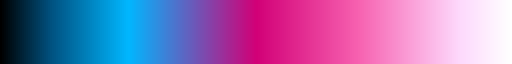

In [5]:
cmap_custom_mult

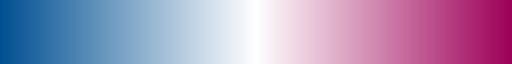

In [6]:
cmap_custom_binary

In [7]:
# UPLOAD FITTING RESULTS
files_missing = []
dict_fitting = {}
for isub, sub in enumerate(subs):
    dict_sub = {}
    for irun, run in enumerate(runs):
        filename = f"sub_{sub}_run_{run}"
        filepath = f"./results/results_fitting/{filename}.zip"
        if os.path.exists(filepath):
            with zipfile.ZipFile(filepath, 'r') as zipf:
                with zipf.open(f"{filename}.pkl") as f:
                    dict_run = pickle.load(f)
            dict_sub[run] = dict_run
        else:
            files_missing.append(filename)
    dict_fitting[sub] = dict_sub
print(f'Number of files missing: {len(files_missing)}')

# STORE
# TODO: check if all arrays are used, rethink naming
ts_raw_fit = np.zeros((len(subs), len(runs), 400, 200), dtype=np.float32)
ts_eeg_fit = np.zeros((len(subs), len(runs), 400, 62), dtype=np.float32)
fits_cos_sim_all = np.zeros((len(subs), len(runs)), dtype=np.float32)
fits_pcc_all = fits_cos_sim_all.copy()
fits_cos_sim_course = np.zeros((len(subs), len(runs), n_epochs), dtype=np.float32)
fits_pcc_course = np.zeros((len(subs), len(runs), n_epochs), dtype=np.float32)
scs_all = np.zeros((len(subs), len(runs), 200, 200))
for isub, sub in enumerate(subs):
    for irun, run in enumerate(runs):
        raw = dict_fitting[sub][run]['ts_raw_fitted']
        ts_raw_fit[isub, irun] = raw
        ts_eeg_fit[isub, irun] = 0.0005 * np.matmul(leadfield_matrix, raw.T).T
        fits_cos_sim_all[isub, irun] = dict_fitting[sub][run]['course_cos_sim'][-1]
        fits_pcc_all[isub, irun] = dict_fitting[sub][run]['course_pcc'][-1]
        fits_cos_sim_course[isub, irun] = dict_fitting[sub][run]['course_cos_sim']
        fits_pcc_course[isub, irun] = dict_fitting[sub][run]['course_pcc']
        scs_all[isub, irun] = dict_fitting[sub][run]['fitted_sc']

# UPLOAD SIMULATION RESULTS
# GMFA (all time points)
sim_res_gmfa = np.zeros((len(subs), len(runs), len(factors_explore), len(factors_values), int(300/dtx)), dtype=np.float32) # (20,100,2,51,1200)
for isub, sub in enumerate(subs):
    dict_sub = {}
    for irun, run in enumerate(runs):
        filename = f"sub_{sub}_run_{run}"
        filepath = f"./results/results_simulation/gmfa/{filename}_gmfa.zip"
        with zipfile.ZipFile(filepath, 'r') as zipf:
            with zipf.open(f"{filename}_gmfa.npy", 'r') as f:
                sim_res_gmfa[isub, irun] = np.load(f)

gmfa_tep_relative = np.zeros((len(factors_explore), len(runs), len(subs), len(factors_values)), dtype=np.float32) # (2, 100, 20, 6, 21) = (factors, runs, subjects, x+y values, parameter values explored)
gmfa_tep_absolute = gmfa_tep_relative.copy()
# GMFA (sum of the TEP)
index_default = 25
range_gmfa = [55, 275]
for ifx, fx in enumerate(factors_explore):
    for irun, run in enumerate(runs):
        for isub, sub in enumerate(subs):
            gmfa_sub_default = np.sum(sim_res_gmfa[isub, irun, ifx, index_default, int(range_gmfa[0]/dtx):int(range_gmfa[1]/dtx)])  # GMFA of TEP of the subject at default
            gmfa_sub = np.sum(sim_res_gmfa[isub, irun, ifx, :, int(range_gmfa[0]/dtx):int(range_gmfa[1]/dtx)], axis=1)  # GMFA of TEP of the subject at all values of parameter
            gmfa_tep_relative[ifx, irun, isub] = (gmfa_sub / gmfa_sub_default)*100
            gmfa_tep_absolute[ifx, irun, isub] = gmfa_sub - gmfa_sub_default

# OUTLIERS
outlier_threshold = 3
sub_count = []
run_count = 0
fits_pcc_out = fits_pcc_all.copy()
fits_pcc_course_out = fits_pcc_course.copy()
sim_res_gmfa_out = sim_res_gmfa.copy()
gmfa_tep_relative_out = gmfa_tep_relative.copy()
gmfa_tep_absolute_out = gmfa_tep_absolute.copy()

for isub, sub in enumerate(subs):
    mean = np.mean(fits_pcc_all[isub])
    std = np.std(fits_pcc_all[isub])
    for irun, run in enumerate(runs):
        fit = fits_pcc_all[isub, irun]
        if fit < mean-outlier_threshold*std or fit > mean+outlier_threshold*std:
            fits_pcc_out[isub, irun] = np.nan
            fits_pcc_course_out[isub, irun] = np.nan
            sim_res_gmfa_out[isub, irun] = np.nan
            gmfa_tep_relative_out[:, irun, isub] = np.nan
            gmfa_tep_absolute_out[:, irun, isub] = np.nan
            sub_count.append(sub)
            run_count += 1
print(f"Number of outliers: {run_count}")


Number of files missing: 0
Number of outliers: 9


### Correlation Plots

In [8]:
# # PCC: histogram, per subject, outliers included
# # TODO: Include outliers?
# fig, axs = plt.subplots(4, 5, figsize=(fig_width+3, 12), dpi=resolution)
# fig.suptitle('Pearson Correlation Coefficient (PCC) between empirical & simulated TEPs\nN=100 Fitting Runs per Subject')
# axs = axs.flatten()
# for isub, sub in enumerate(subs):
#     mean = np.nanmean(fits_pcc_out[isub])
#     std = np.nanstd(fits_pcc_out[isub])
#     axs[isub].hist(fits_pcc_out[isub], bins=20, color=cmap_custom_mult(0.7))
#     axs[isub].axvline(mean, linestyle="--", lw=2, color=cmap_custom_mult(0.05), label="mean")
#     axs[isub].axvline(mean-3*std, linestyle="--", lw=2, color=cmap_custom_mult(0.25), label="3*std")
#     axs[isub].axvline(mean+3*std, linestyle="--", lw=2, color=cmap_custom_mult(0.25))
#     axs[isub].set_title(f"sub-{subs_bids[isub]}")
# axs[0].set_xlabel('PCC')
# axs[0].set_ylabel('Density')
# axs[0].legend()
# plt.tight_layout()
# # plt.savefig(f"{dir_exp}correlation_pcc_per_subject_with_outliers.png", transparent=True)
# plt.show()

In [9]:
# # PCC: Plot fits over epochs
# plt.figure(figsize=(fig_width-5, 6), dpi=resolution)
# plt.title("Pearson correlation coefficient (PCC)\nper Subject & Epoch, averaged over 100 Fitting Runs")
# for isub, sub in enumerate(subs):
#     col = cmap_custom_mult(isub / (len(subs)+4))
#     plt.plot(np.nanmean(fits_cos_sim_course[isub] , axis=0), label=f"sub-{subs_bids[isub]}", color=col)
# plt.xlabel("Epochs")
# plt.ylabel("PCC")
# plt.xlim(0, n_epochs)
# plt.legend(loc='lower right', ncol=3)
# plt.savefig(f"{dir_exp}correlation_pcc_course_per_subject.png", transparent=True)
# plt.show()

In [10]:
# # PCC: violin plots, overall
# plt.figure(figsize=(fig_width-8, 5), dpi=300)
# plt.title("Correlation of Empirical & Simulated TEPs\n20 subjects & 100 fitting repetitions (n=2000)")
# plt.title('Pearson Correlation Coefficient (PCC)\nbetween empirical & simulated TEPs\n20 Subjects & 100 Fitting Runs (n=2000)')
# sns.violinplot(data=fits_pcc_out.flatten(), color=cmap_custom_mult(0.7), orient='h')
# plt.xlabel('Pearson correlation coefficient')
# plt.ylabel('Density')
# plt.yticks([])
# plt.tight_layout()
# # plt.savefig(f"{dir_exp}correlation_pcc_violin.png", transparent=True)
# plt.show()

### Timeseries Plots

In [11]:
# pcc_calculation = np.zeros((len(subs), 4, 62))

# fig, axs = plt.subplots(nrows=len(subs), ncols=3, figsize=(fig_width+5,60), dpi=resolution)
# fig.suptitle(f"Empirical & Simulated EEG Timeseries, Simulated RAW Timeseries\nwith Pearson correlation coefficient (PCC)")
# for isub, sub in enumerate(subs):
#     # Empirical EEG
#     color = iter(cm.rainbow(np.linspace(0, 1, 62)))
#     for j in range(62):
#         col = next(color)
#         axs[isub, 0].plot(np.arange(-50, 300), empirical_timeseries[isub][j, 950:1300].T, c=col, alpha=0.6)
#     axs[isub, 0].axvline(x=0, color='r', linestyle='--', label='Stimulus')
#     axs[isub, 0].set_xlim(-50, 300)
#     axs[isub, 0].set_ylabel(f'sub-{subs_bids[isub]}')

#     # Simulated EEG (TVB)
#     color = iter(cm.rainbow(np.linspace(0, 1, 62)))
#     for j in range(62):
#         col = next(color)
#         axs[isub, 1].plot(np.arange(-50, 300), ts_eeg_fit[isub, 0, int(50):, j], c=col, alpha=0.6)
#         channel_emp = empirical_timeseries[isub][j, 900:1300].T
#         channel_sim = ts_eeg_fit[isub, 0, :, j]
#         r, p = scipy.stats.pearsonr(channel_emp, channel_sim)
#         pcc_calculation[isub, 0, j] = r
#         pcc_calculation[isub, 1, j] = p
#     p_value = np.round(np.mean(pcc_calculation[isub, 1]), 4)
#     p_label = p_value if p_value >= 0.001 else "<0.001"
#     axs[isub, 1].set_xlabel(f'PCC: r={np.round(np.mean(pcc_calculation[isub, 0]), 4)}, p={p_label}')
#     axs[isub, 1].axvline(x=0, color='r', linestyle='--', label='Stimulus')
#     axs[isub, 1].set_xlim(-50, 300)

#     # Simulated RAW (TVB)
#     for j in range(200):
#         if j == 0 or j==23:
#             continue
#         axs[isub, 2].plot(np.arange(-50,300), ts_raw_fit[isub, 0, int(50):, j], alpha=0.2, c='red' if stimulus_spatial[j] != 0 else 'black')
#     axs[isub, 2].plot(np.arange(-50,300), ts_raw_fit[isub, 0, int(50):, 23], alpha=0.2, c='red', label='stimulated area')
#     axs[isub, 2].plot(np.arange(-50,300), ts_raw_fit[isub, 0, int(50):, 0], alpha=0.2, c='black', label='not stimulated area')
#     axs[isub, 2].axvline(x=0, color='r', linestyle='--', label='Stimulus')
#     axs[isub, 2].set_xlim(-50, 300)
    
#     # Plot settings
#     axs[0,0].set_title("Empirical EEG")
#     axs[0,1].set_title("Simulated EEG (TVB)")
#     axs[0,2].set_title("Simulated RAW (TVB)")
#     axs[0,2].legend()

# axs[0][0].set_xlabel('time (ms)')
# axs[0][0].set_ylabel('sub-01\nEEG amplitude (µV)')
# axs[0][1].set_ylabel('EEG amplitude (µV)')
# axs[0][2].set_ylabel('Local Field Potentials')

# plt.tight_layout()
# plt.subplots_adjust(top = 0.93, left = 0.08)
# plt.savefig(f"{dir_exp}all_timeseries.png", transparent=True)
# plt.close()

### Method Plots

In [19]:
ticks = [50, 100, 150, 200]
sub_choice = 14
sc_fitted_example = dict_fitting[subs[sub_choice]][0]['fitted_sc']
raw_fitted_example = ts_raw_fit[sub_choice, 0]
eeg_fitted_example = ts_eeg_fit[sub_choice, 0]

# # empirical TEP
# ts_emp_choice = empirical_timeseries[sub_choice][:,950:1300].T
# cmap_empirical = cm.gray.reversed()
# color = iter(cmap_empirical(np.linspace(0, 1, 120)))
# plt.figure(figsize=(6,3.5), dpi=resolution)
# for j in range(50):
#     col = next(color)
# for j in range(62):
#     col = next(color)
#     plt.plot(np.arange(-50,300), ts_emp_choice[:,j], color=col, alpha=0.8)
# plt.axvline(x=0, color='red', linestyle='--', label='Stimulus')
# # plt.title(f'Empirical EEG (sub-{subs_bids[sub_choice]})')
# plt.xlim(-50,300)
# plt.legend(loc='lower right')
# plt.ylabel('Amplitude (µV)')
# plt.xlabel('Time (ms)')
# plt.tight_layout()
# # plt.savefig(f"{dir_exp}methodplot_TEP_empirical_sub{sub_choice}_v2.png", transparent=True)
# plt.show()

# # input SC
# plt.figure(figsize=(7,4), dpi=resolution)
# im = plt.imshow(sc_weights_norm, cmap=cmap_custom_mult)
# plt.xlabel('Region')
# plt.ylabel('Region')
# cbar = plt.colorbar(im, label="Connection Weights")
# cbar.set_label("Connection Weights")
# plt.xticks(ticks)
# plt.yticks(ticks)
# plt.tight_layout()
# plt.savefig(f"{dir_exp}methodplot_sc_weights.png", transparent=True)
# plt.show()


# # fitted SC
# plt.figure(figsize=(7,4), dpi=resolution)
# im = plt.imshow(sc_fitted_example, cmap=cmap_custom_mult)
# plt.xlabel('Region')
# plt.ylabel('Region')
# cbar = plt.colorbar(im, label="Connection Weights")
# cbar.set_label("Connection Weights")
# plt.xticks(ticks)
# plt.yticks(ticks)
# plt.tight_layout()
# plt.savefig(f"{dir_exp}methodplot_sc_fitted_normal.png", transparent=True)
# plt.show()

# # fitted SC logarithmized
# from matplotlib.colors import LogNorm
# plt.figure(figsize=(7,4), dpi=resolution)
# im = plt.imshow(sc_fitted_example, cmap=cmap_custom_mult, norm=LogNorm())
# plt.xlabel('Region')
# plt.ylabel('Region')
# cbar = plt.colorbar(im, label="Connection Weights")
# cbar.set_label("Connection Weights")
# plt.xticks(ticks)
# plt.yticks(ticks)
# plt.tight_layout()
# plt.savefig(f"{dir_exp}methodplot_sc_fitted_logarithmized.png", transparent=True)
# plt.show()

# # fitted SC logarithmized and 0 replaced
# from matplotlib.colors import LogNorm
# small_value = np.min(sc_fitted_example[np.where(sc_fitted_example != 0)])
# sc_fitted_replaced = np.where(sc_fitted_example == 0, small_value, sc_fitted_example)
# plt.figure(figsize=(7, 4), dpi=resolution)
# im = plt.imshow(sc_fitted_replaced, cmap=cmap_custom_mult, norm=LogNorm())
# plt.xlabel('Region')
# plt.ylabel('Region')
# cbar = plt.colorbar(im, label="Connection Weights")
# cbar.set_label("Connection Weights")
# cbar.ax.text(1.9, 0, '0', ha='left', va='center', transform=cbar.ax.transAxes)
# plt.xticks(ticks)
# plt.yticks(ticks)
# plt.tight_layout()
# plt.savefig(f"{dir_exp}methodplot_sc_fitted_logarithmized_0_replaced.png", transparent=True)
# plt.show()

# # big timeseries plot
# ex_low = eeg_fitted_example[50:] * 0.75
# ex_def = eeg_fitted_example[50:]
# ex_high = eeg_fitted_example[50:] * 1.25
# gmfa_low = [gmfa(ex_low, i, i+1) for i in range(350)]
# gmfa_def = [gmfa(ex_def, i, i+1) for i in range(350)]
# gmfa_high = [gmfa(ex_high, i, i+1) for i in range(350)]

# # fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(fig_width/2,fig_width-2), dpi=resolution, gridspec_kw={'height_ratios': [1, 1, 1, 0.001, 1]})
# fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(6,fig_width-2), dpi=resolution, gridspec_kw={'height_ratios': [1, 1, 1, 0.001, 1]})
# color = iter(cmap_custom_binary(np.linspace(0, 1, 2*62)))
# for j in range(62):
#     col = next(color)
# for j in range(62):
#     col = next(color)
#     axs[0].plot(np.arange(-50,300), ex_low[:,j], c=col, alpha=0.8)
# color = iter(cm.BuPu.reversed()(np.linspace(0, 1, 200)))
# for j in range(62):
#     col = next(color)
#     axs[1].plot(np.arange(-50,300), ex_def[:,j], c=col, alpha=0.8)
# color = iter(cmap_custom_binary.reversed()(np.linspace(0, 1, 2*62)))
# for j in range(62):
#     col = next(color)
# for j in range(62):
#     col = next(color)
#     axs[2].plot(np.arange(-50,300), ex_high[:,j], c=col, alpha=0.8)
# axs[0].set_ylim(-6.8,10.1)
# axs[1].set_ylim(-6.8,10.1)
# axs[2].set_ylim(-6.8,10.1)
# axs[4].plot(np.arange(-50,300), gmfa_high, color='blue', label='Low b', lw=4)
# axs[4].plot(np.arange(-50,300), gmfa_def, color='purple', label='Default b', lw=4)
# axs[4].plot(np.arange(-50,300), gmfa_low, color='red', label='High b', lw=4)

# for i, ax in enumerate(axs):
#     if i != 3:
#         ax.set_ylabel('Amplitude (µV)' if i < 3 else 'GMFA')
#         ax.set_xlabel('Time (ms)')
#         ax.set_xlim(-50, 300)
#         ax.axvline(x=0, color='red', linestyle='--', label='Stimulus')
#         ax.legend(loc='upper right')
# axs[3].axis('off')
# plt.tight_layout()
# # plt.savefig(f"{dir_exp}methodplot_TEP_GMFA_sim.png", transparent=True)
# plt.show()

In [20]:
# # 3D stimulus plot - plot with different environment 
# import pyvista as pv
# dir_save_obj = '/Users/timo/Documents/TMS/Visualizations/paper/schaefer_200_7n_objs/'
# schaefer_tess = scipy.io.loadmat("./data/tess_Schaefer2018_200_7net.mat")
# stimulus_spatial_alt = stimulus_spatial.copy() * 2.4375
# stimulus_spatial_alt[stimulus_spatial_alt == 0] = -0.24375

# schaefer_region_list = []
# atlas_regions_vertices = []
# for i in range(200):
#     schaefer_region_list.append(schaefer_tess['Atlas'][0][1][1][0][i][-4][0])
#     atlas_regions_vertices.append(schaefer_tess['Atlas'][0][1][1][0][i][0][0])
# start_values_with_indices = [(arr[0], idx) for idx, arr in enumerate(atlas_regions_vertices)]
# sorted_start_values_with_indices = sorted(start_values_with_indices)
# index_array = [idx for _, idx in sorted_start_values_with_indices]
# list_obj_files = []
# for ireg, reg in enumerate(index_array):
#     region_name = schaefer_region_list[reg]
#     filename = f"schaefer_200_2n_{reg}_{region_name}.obj"
#     list_obj_files.append(filename)
# list_mesh = []
# for obj in list_obj_files:
#     mesh = pv.read(dir_save_obj+obj)
#     list_mesh.append(mesh)
# stimulus_spatial_alt = stimulus_spatial.copy()
# stimulus_spatial_alt[stimulus_spatial_alt == 0] = -0.1
# for i in range(len(list_mesh)):
#     list_mesh[i].cell_data["data"] = stimulus_spatial_alt[i] * 2.4375

# x = 2200
# y = 1600
# p = pv.Plotter(window_size=(x, y))
# # p.add_axes(interactive=True, xlabel='X', ylabel='Y', zlabel='Z')   
# for mesh in list_mesh:
#     p.add_mesh( mesh, scalars = "data", clim = [-0.1,2.5], cmap = cmap_custom_stim,
#                 scalar_bar_args={'font_family':'times', 'color': 'black', 'title': ' ', 'vertical': True, 
#                                 'position_x': 0.85, 'position_y': 0.2, 'label_font_size': 100, 'height': 0.6,'width': 0.075})
# p.camera.roll = -130
# p.set_position([0,0.4,0.25])
# p.background_color = 'white'
# p.screenshot(f"{dir_exp}methodplot_stimulus_spatial_3D.png")
# # p.show(jupyter_backend='ipygani')
# p.show()

# # random plot for colorbar of stimulus plot
# plt.figure(figsize=(7,4), dpi=resolution)
# im = plt.imshow(sc_weights_norm*1000, vmax=2.5, cmap=cmap_custom_stim)
# plt.xlabel('Region')
# plt.ylabel('Region')
# cbar = plt.colorbar(im, label="Connection Strength")
# cbar.set_label("Electric Field (V/m)")
# plt.tight_layout()
# # plt.savefig(f"{dir_exp}methodplot_stimulus_spatial_3D_colorbar.png", transparent=True)
# plt.show()

### Results Plots

In [14]:
# fig, ax = plt.subplots(2, 1, figsize=(fig_width-2,10), dpi=resolution)#, gridspec_kw={'hspace': 0.05})

# for ifx, fx in enumerate(factors_explore):
#     axs=ax[ifx]
#     mean_per_subject = np.nanmean(gmfa_tep_relative_out[ifx], axis=0).T
#     mean = np.nanmean(mean_per_subject, axis=1)
#     std = np.nanstd(mean_per_subject, axis=1)

#     axs.plot(factors_values_b_c4[ifx], mean, color="black", lw=2, label="GMFA mean")
#     polygon = axs.fill_between(factors_values_b_c4[ifx], mean-std, mean+std, alpha=0.5, color='none', label="GMFA standard deviation")
#     verts = np.vstack([p.vertices for p in polygon.get_paths()])
#     gradient = axs.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=cmap_custom_binary, aspect='auto', alpha=0.5,
#                         extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
#     gradient.set_clip_path(polygon.get_paths()[0], transform=axs.transData)

#     # linear regression
#     x = factors_values_b_c4[ifx]
#     y = mean.copy()
#     slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#     line = slope * x + intercept
#     p_label = np.round(p_value,3) if p_value >= 0.001 else "<0.001"
#     axs.plot(factors_values_b_c4[ifx], line, linestyle='--', color='black', lw=6, label=f"Linear Regression\nr={r_value:.2f}, p={p_label}")

#     axs.axhline(y=100, color='dimgray', linestyle='dotted', lw=3, label="Default GMFA (100%)")#, label='default value')    
#     axs.set_xlabel(parameter_description[ifx])
#     axs.set_xlim(factors_values_b_c4[ifx][0], factors_values_b_c4[ifx][-1])
#     axs.legend(loc="upper center")

# ax[0].set_ylabel(f"global mean field amplitude\n(GMFA (% of default))")
# ax[1].set_ylabel(f"GMFA (% of default)")

# plt.tight_layout()
# # plt.savefig(f'{dir_exp}results_main_out_tep.png', transparent=True)
# plt.show()

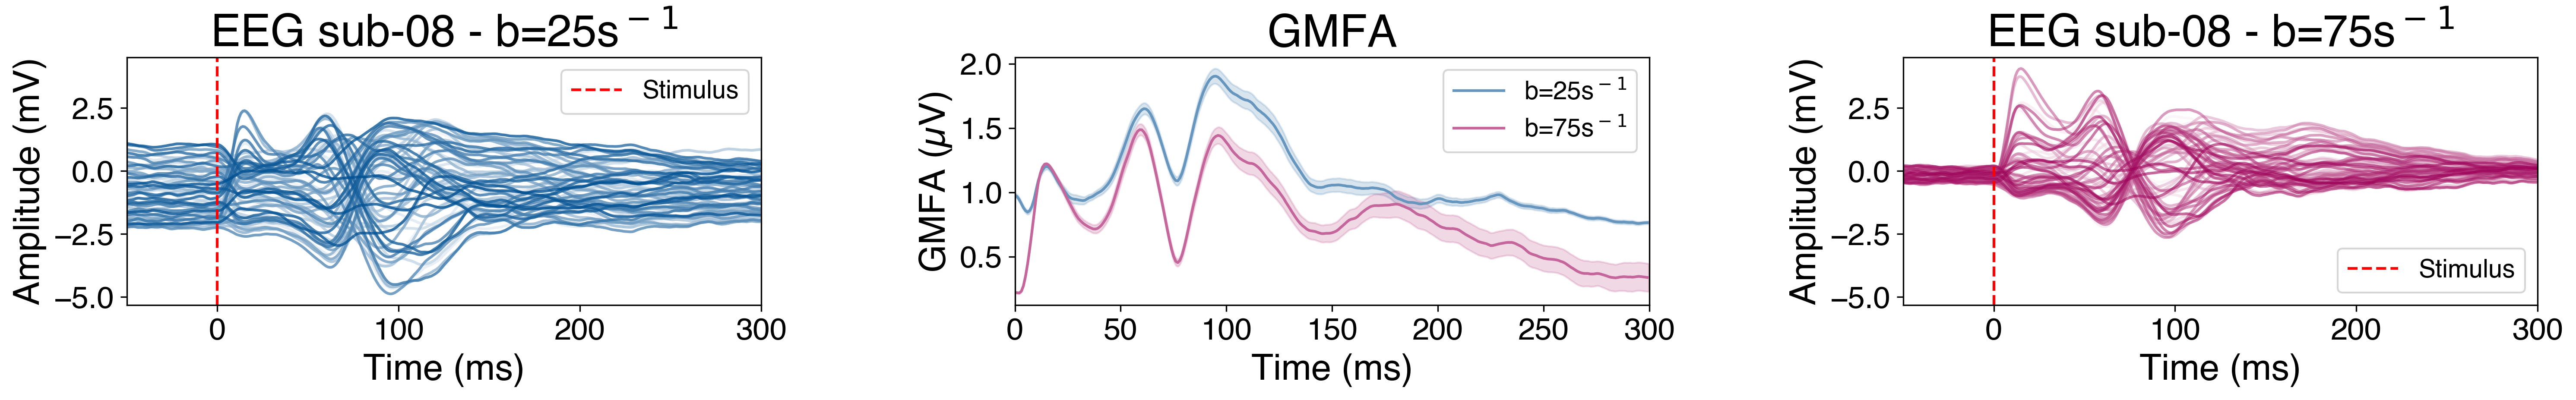

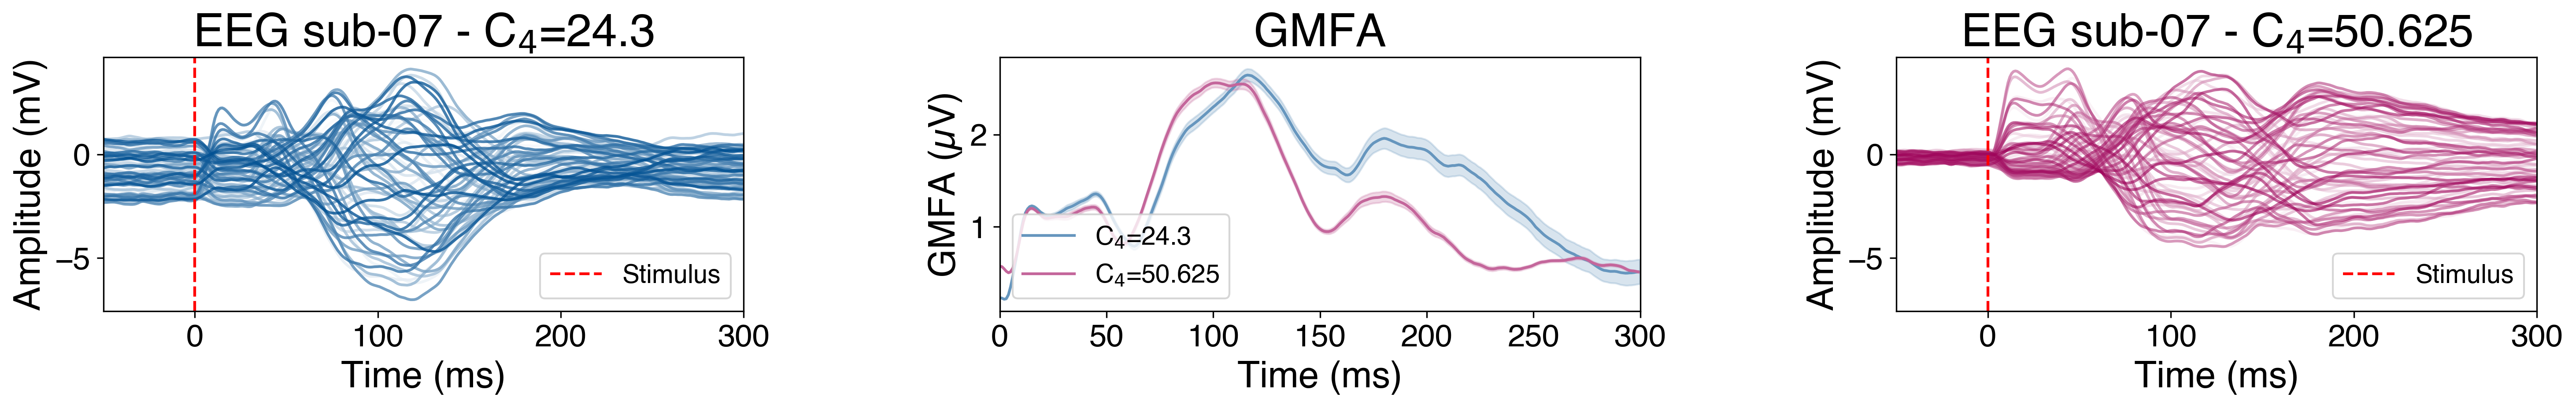

In [26]:
# # EEG AND GMFA PLOTS FOR LOW AND HIGH B AND C4 - RESULTS PLOT
# # b plots
# # choose and upload data
# sub_b_choice = 8
# idx_b_low = 0
# idx_b_high = -1
# filename = f"sub_{sub_b_choice}_run_0"
# filepath = f"./results/results_simulation/eeg/{filename}_eeg.zip"
# with zipfile.ZipFile(filepath, 'r') as zipf:
#     with zipf.open(f"{filename}_eeg.npy", 'r') as f:
#         example_b = np.load(f)
# eeg_b_low = example_b[0,idx_b_low][::4,:]
# eeg_b_high = example_b[0,idx_b_high][::4,:]

# fig, ax = plt.subplots(1, 3, figsize=(20,3.4), dpi=300)
# cmap = cmap_custom_binary
# color = iter(cmap_custom_binary.reversed()(np.linspace(0, 1, 2*62)))
# for j in range(62):
#     col = next(color)
# for j in range(62):
#     col = next(color)
#     ax[0].plot(np.arange(-50, 300), eeg_b_low[int(50):, j], c=col, alpha=0.8)
# ax[0].set_ylabel('Amplitude (mV)')
# ax[0].set_title(f"EEG sub-0{sub_b_choice} - b={int(factors_values_b_c4[0,idx_b_low])}s$^-$$^1$")
# ax[0].axvline(x=0, color='r', linestyle='--', label='Stimulus')
# ax[0].set_xlim(-50, 300)
# ax[0].legend(loc="upper right", fontsize=14)
# for i, idx_value in enumerate([idx_b_low, idx_b_high]):
#     gmfa_mean = np.nanmean(sim_res_gmfa_out[sub_b_choice,:,0,idx_value,:], axis=(0))
#     gmfa_std = np.nanstd(sim_res_gmfa_out[sub_b_choice,:,0,idx_value,:], axis=(0))
#     ax[1].plot(gmfa_mean[::4], label=f"b={int(factors_values_b_c4[0, idx_value])}s$^-$$^1$", color=cmap([0.2, 0.8][i]))
#     ax[1].fill_between(np.arange(0,len(gmfa_mean)*dtx,dtx), gmfa_mean-gmfa_std, gmfa_mean+gmfa_std, alpha=0.25, color=cmap([0.2, 0.8][i]))
#     ax[1].legend(loc="upper right", fontsize=14)
# ax[1].set_xlim(0,300)
# ax[1].set_ylabel('GMFA (µV)')
# ax[1].set_title(f"GMFA")
# color = iter(cmap_custom_binary(np.linspace(0, 1, 2*62)))
# for j in range(62):
#     col = next(color)
# for j in range(62):
#     col = next(color)
#     ax[2].plot(np.arange(-50, 300), eeg_b_high[int(50):, j], c=col, alpha=0.6)
# ax[2].set_ylabel('Amplitude (mV)')
# ax[2].set_title(f"EEG sub-0{sub_b_choice} - b={int(factors_values_b_c4[0,idx_b_high])}s$^-$$^1$")
# ax[2].sharey(ax[0])
# ax[2].axvline(x=0, color='r', linestyle='--', label='Stimulus')
# ax[2].set_xlim(-50, 300)
# ax[2].legend(loc="lower right", fontsize=14)
# for i in range(3):
#     axs = ax[i]
#     axs.set_xlabel("Time (ms)")
# fig.tight_layout()
# plt.subplots_adjust(wspace=0.4)
# plt.savefig(f'{dir_exp}resultsplot_timeseries_gmfa_b_sub_{sub_b_choice}.png', transparent=True)
# plt.show()


# # C4 Plots
# sub_c4_choice = 7
# idx_c4_low = 11
# idx_c4_high = -1
# filename = f"sub_{sub_c4_choice}_run_0"
# filepath = f"./results/results_simulation/eeg/{filename}_eeg.zip"
# with zipfile.ZipFile(filepath, 'r') as zipf:
#     with zipf.open(f"{filename}_eeg.npy", 'r') as f:
#         example_c4 = np.load(f)
# eeg_c4_low = example_c4[0,idx_b_low][::4,:]
# eeg_c4_high = example_c4[0,idx_b_high][::4,:]

# fig, ax = plt.subplots(1, 3, figsize=(20,3.4), dpi=300)
# color = iter(cmap_custom_binary.reversed()(np.linspace(0, 1, 2*62)))
# for j in range(62):
#     col = next(color)
# for j in range(62):
#     col = next(color)
#     ax[0].plot(np.arange(-50, 300), eeg_c4_low[int(50):, j], c=col, alpha=0.8)
# ax[0].set_ylabel('Amplitude (mV)')
# ax[0].set_title(f"EEG sub-0{sub_c4_choice} - C$_4$={np.round(factors_values_b_c4[1,idx_c4_low],3)}")
# ax[0].axvline(x=0, color='r', linestyle='--', label='Stimulus')
# ax[0].set_xlim(-50, 300)
# ax[0].legend(loc="lower right", fontsize=14)
# for i, idx_value in enumerate([idx_c4_low, idx_c4_high]):
#     gmfa_mean = np.nanmean(sim_res_gmfa_out[sub_c4_choice,:,1,idx_value,:], axis=(0))
#     gmfa_std = np.nanstd(sim_res_gmfa_out[sub_c4_choice,:,1,idx_value,:], axis=(0))
#     ax[1].plot(gmfa_mean[::4], label=f"C$_4$={np.round(factors_values_b_c4[1, idx_value],3)}", color=cmap([0.2, 0.8][i]))
#     ax[1].fill_between(np.arange(0,len(gmfa_mean)*dtx,dtx), gmfa_mean-gmfa_std, gmfa_mean+gmfa_std, alpha=0.25, color=cmap([0.2, 0.8][i]))
#     ax[1].legend(loc="lower left", fontsize=14)
# ax[1].set_xlim(0,300)
# ax[1].set_ylabel('GMFA (µV)')
# ax[1].set_title(f"GMFA")
# color = iter(cmap_custom_binary(np.linspace(0, 1, 2*62)))
# for j in range(62):
#     col = next(color)
# for j in range(62):
#     col = next(color)
#     ax[2].plot(np.arange(-50, 300), eeg_c4_high[int(50):, j], c=col, alpha=0.6)
# ax[2].set_ylabel('Amplitude (mV)')
# ax[2].set_title(f"EEG sub-0{sub_c4_choice} - C$_4$={np.round(factors_values_b_c4[1,idx_c4_high],3)}")
# ax[2].sharey(ax[0])
# ax[2].axvline(x=0, color='r', linestyle='--', label='Stimulus')
# ax[2].set_xlim(-50, 300)
# ax[2].legend(loc="lower right", fontsize=14)
# for i in range(3):
#     axs = ax[i]
#     axs.set_xlabel("Time (ms)")
# fig.tight_layout()
# plt.subplots_adjust(wspace=0.4)
# plt.savefig(f'{dir_exp}resultsplot_timeseries_gmfa_c4_sub_{sub_c4_choice}.png', transparent=True)
# plt.show()

### Supplementary Plots

In [136]:
# def h_block(t, H, tau):
#     h = H * t / tau * np.exp(-t / tau)
#     h[h < 0] = 0
#     return h

# def sigma_equation(x, e0=2.5, v0=6, r=0.56):
#     y = 2 * e0 / (1 + np.exp(r * (v0 - x)))
#     return y

# def r_line(x, r=0.56, v0=6, e0=2.5):
#     y = r * (x - v0) + e0
#     return y

# # Plotting parameters
# min_t = 0
# max_t = 0.2
# t = np.arange(min_t, max_t, 1/10000)

# light_red = (255/255, 150/255, 150/255)  # RGB for light red
# red = (255/255, 0, 0)  # RGB for red
# dark_red = (120/255, 0, 0)  # RGB for dark red


# plt.figure(figsize=(fig_width,fig_width/3), dpi=resolution)
# plt.subplot(1, 2, 1)
# H = 3.25
# b_values = [25, 50, 75]
# colors = [light_red, red, dark_red]
# for b, color in zip(b_values, colors):
#     tau = 1/b
#     plt.plot(t, h_block(t, H, tau), lw=3, c=color, label=f'τ = {tau:.3f} s/b = {b} s$^{{-1}}$')

# plt.title('Inhibitory h-Block Function\nDefault Parameters & b Alterations')
# plt.xlabel('Time (s)')
# plt.ylabel('Potential (mV)')
# plt.xlim(min_t, max_t)
# plt.ylim(-0.05, 1.25)
# plt.legend(loc='upper right')
# plt.grid(False)

# potential_values = np.arange(-9, 21, 0.1)
# C4_values = [16.875, 33.75, 50.625]
# colors = ['#B0C4DE', 'blue', 'navy']

# plt.subplot(1, 2, 2)
# activation_rates = [sigma_equation(pot) for pot in potential_values]
# plt.plot(potential_values, activation_rates*np.array((33.75*0.5)), lw=3, c=colors[0], label=f'$C_4={C4_values[0]}$')
# plt.plot(potential_values, activation_rates*np.array((33.75)), lw=3, c=colors[1], label=f'$C_4={C4_values[1]}$')
# plt.plot(potential_values, activation_rates*np.array((33.75*1.5)), lw=3, c=colors[2], label=f'$C_4={C4_values[1]}$')


# plt.axvline(x=6, color='gray', linestyle='--')
# plt.axhline(y=2.5*np.array((33.75)), color='gray', linestyle='--')
# plt.plot(potential_values, r_line(potential_values, r=0.56, v0=6)*np.array((33.75)), linestyle='--', color='gray')
# plt.text(6.5, 1, r'$v_0 = 6 \, \mathrm{mV}$')
# plt.text(8.3, 106, r'$r = 0.56$')
# plt.text(-8.3, 98, r'$v_{max} = 2.5\, \mathrm{s}^{-1}(*33.75)$')
# plt.title('Sigmoidal Function\nDefault Parameters & $C_4$ Alterations')
# plt.xlabel('Potential (mV)')
# plt.ylabel('Firing Rate (s$^{-1}$)')
# plt.xlim(-9, 21)
# plt.ylim(-10, 275)
# plt.legend(loc='upper left')
# plt.grid(False)

# plt.tight_layout()
# # plt.savefig(f"{dir_exp}supplementary_JR_functions.png", transparent=True)
# plt.show()